In [20]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display

import sys 
sys.path.append('../../modules/')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline, eumf_custom_models
from tqdm import tqdm
from sklearn import preprocessing, pipeline, linear_model, impute, model_selection

from typing import Optional, Iterable

# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

### Load all data

In [21]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True, countries=countries)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()

# macroeconomic data
df_gdp = eumf_data.read_gdp(countries=countries)
df_unempl = eumf_data.read_unempl(countries=countries)

### Join data, combine countries

In [22]:
country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


10                                                                                                                       11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                unempl                                                                                                      
country     AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB    GR   HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR     HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB      GR      HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB        GR        HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB    GR    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                            
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381  0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  10.000  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286   9.000  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2327.333  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0  3760.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  22.4  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857  0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   4.714  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  11.905  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2113.333  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  4120.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  21.8  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.429  21.048  16.

## Experiments

### Common definitions

In [23]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2019"
T_TEST_MAX = "2019"

cv_default = eumf_eval.BlockKFold(n_splits=8, margin=1.0)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
# n_countries = len(panel_comb_3m_macro["value"].columns)
# cv_time = model_selection.TimeSeriesSplit(test_size=4 * n_countries, n_splits=6)

### LinReg - possible feature combinations

In [24]:
### TRAINING
lags_default = [1, 2, 3, 4, 5, 6]
alternate_lags_default = {
    "value": [2, 3, 4, 5, 6],
    "gdp": [2, 3, 4, 5, 6],
    "unempl": [2, 3, 4, 5, 6],
}


model_names = [
    "bench-rw",
    "bench-rw-realistic",
    "19",
    "gdp+unempl",
    "19+gdp+unempl",
    "ar",
    "ar+19",
    "ar+gdp+unempl",
    "ar+19+gdp+unempl",
]

feature_combinations = [
    ["value"],
    ["value"],
    ["19"],
    ["gdp", "unempl"],
    ["19", "gdp", "unempl"],
    ["value"],
    ["value", "19"],
    ["value", "gdp", "unempl"],
    ["value", "19", "gdp", "unempl"],
]

lags = [
    [1],
    [2],
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
]

alternate_lags = [
    {},
    {},
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
]

use_linear_dummy = [True, True, False, False, False, False, False, False, False]

tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {
    "lasso__fit_intercept": [True, False],
    "lasso__alpha": [0.0001, 0.0004, 0.001, 0.004, 0.01, 0.04]
    # "linearregression__positive": [True, False],
}

for i, name in enumerate(tqdm(model_names)):

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro,
        columns=feature_combinations[i],
        lags=lags[i],
        alternate_lags=alternate_lags[i],
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    if use_linear_dummy[i]:
        tuner = None
        estimator = eumf_custom_models.make_linear_dummy_model(
            train_stacked, features=[feature_combinations[i][0] + "_" + str(lags[i][0])]
        )
    else:
        tuner = eumf_pipeline.train_reg_model(
            train_stacked,
            reg=linear_model.Lasso(positive=True),
            extra_pipeline_steps=[preprocessing.StandardScaler()],
            params=params,
            dummy_encoder="drop",
            scoring=eumf_eval.scorer_mae,
            cv=cv_default
        )
        estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(estimator, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(estimator, test_stacked,)
    test_scores.append(test_score)


100%|██████████| 9/9 [00:17<00:00,  1.99s/it]


In [25]:
    {
        k: t.best_params_
        for k, t in zip(model_names, tuners)
        if t is not None
    }


{'19': {'lasso__alpha': 0.0001, 'lasso__fit_intercept': True},
 'gdp+unempl': {'lasso__alpha': 0.004, 'lasso__fit_intercept': True},
 '19+gdp+unempl': {'lasso__alpha': 0.001, 'lasso__fit_intercept': True},
 'ar': {'lasso__alpha': 0.0001, 'lasso__fit_intercept': True},
 'ar+19': {'lasso__alpha': 0.004, 'lasso__fit_intercept': True},
 'ar+gdp+unempl': {'lasso__alpha': 0.004, 'lasso__fit_intercept': True},
 'ar+19+gdp+unempl': {'lasso__alpha': 0.004, 'lasso__fit_intercept': True}}

In [26]:
pd.DataFrame(
    {
        k: t.best_params_
        for k, t in zip(model_names, tuners)
        if t is not None
    }
).transpose()



,lasso__alpha,lasso__fit_intercept
19,0.0,True
gdp+unempl,0.004,True
19+gdp+unempl,0.001,True
ar,0.0,True
ar+19,0.004,True
ar+gdp+unempl,0.004,True
ar+19+gdp+unempl,0.004,True


In [27]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time                   score_time                   test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
                     mean    std      sem        mean     std      sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
bench-rw             0.010   0.004  1.575e-03    0.014    0.006  2.007e-03  -0.070   0.013  0.005   -0.105   0.027  0.010           0.414          0.224  0.079     0.505    0.273  0.096      0.057      0.065  0.023
bench-rw-realistic   0.010   0.004  1.457e-03    0.015    0.008  2.689e-03  -0.092   0.020  0.007   -0.139   0.047  0.017           0.107          0.201  0.071     0.231    0.305  0.108      0.034      0.056  0.020
19                   0.010   0.005  1.635e-03    0.009    0.003  9.855e-04  -0.097   0.030  0.011   -0.143   0.055  0.020           0.120          0.272  0.096     0.230    0.334  0.118      0.029      0.044  0.015
gdp+unempl           0.014   0.005  1.649e-03    0.013    0.005  1.789e-03  -0.116   0.034  0.012   -0.159   0.056  0.020          -0.032          0.277  0.098     0.011    0.415  0.147      0.011      0.040  0.014
19+gdp+unempl        0.012   0.003  1.119e-03    0.015    0.006  1.952e-03  -0.095   0.029  0.010   -0.137   0.053  0.019           0.148          0.224  0.079     0.294    0.297  0.105      0.032      0.045  0.016
ar                   0.012   0.004  1.366e-03    0.012    0.004  1.435e-03  -0.089   0.032  0.011   -0.130   0.053  0.019           0.309          0.155  0.055     0.375    0.240  0.085      0.037      0.044  0.015
ar+19                0.012   0.003  9.494e-04    0.015    0.006  2.218e-03  -0.082   0.025  0.009   -0.123   0.049  0.017           0.344          0.136  0.048     0.448    0.195  0.069      0.044      0.049  0.017
ar+gdp+unempl        0.011   0.004  1.292e-03    0.015    0.005  1.944e-03  -0.089   0.026  0.009   -0.128   0.047  0.017           0.308          0.195  0.069     0.366    0.258  0.091      0.037      0.049  0.017
ar+19+gdp+unempl     0.011   0.003  1.051e-03    0.016    0.008  2.900e-03  -0.083   0.022  0.008   -0.122   0.047  0.016           0.347          0.153  0.054     0.442    0.203  0.072      0.044      0.052  0.018

In [28]:
eumf_eval.agg_multiple_test_scores(test_scores, model_names)

,mae,rmse,explained_variance,r2_mod,delta_mae
bench-rw,-0.061,-0.086,0.107,0.215,0.009
bench-rw-realistic,-0.068,-0.094,-0.031,0.069,0.002
19,-0.083,-0.111,-0.053,-0.290,-0.012
gdp+unempl,-0.075,-0.096,-0.131,0.025,-0.005
19+gdp+unempl,-0.065,-0.092,-0.014,0.100,0.005
ar,-0.069,-0.091,0.154,0.130,0.001
ar+19,-0.068,-0.089,0.207,0.159,0.002
ar+gdp+unempl,-0.065,-0.084,0.144,0.255,0.005
ar+19+gdp+unempl,-0.064,-0.082,0.203,0.287,0.006


#### Performance by year (CV+test)

In [29]:
# indices = [4,5,6]
# metrics = ["rmse", "mae", "delta_mae"]

# fold_labels = [2011, 2012, 2013, "HOLDOUT", 2015, 2016, 2017, 2018, 2019]

# for m in metrics:
#     eumf_eval.cv_performance_plot(
#         cv_scores,
#         m,
#         indices=indices,
#         run_labels=feature_combinations,
#         fold_labels=fold_labels,
#         test_scores=test_scores,
#         test_pos=2,
#     )
#     plt.show()


#### Performance by country

##### without value

In [30]:
i = 4

reg = tuners[i].best_estimator_

test_scores_c = eumf_eval.score_test_countries(reg, test_stackeds[i])
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


,mae,rmse,explained_variance,r2_mod,delta_mae
LV+LT+EE,-0.020,-0.024,0.612,0.831,2.547e-02
FR,-0.008,-0.009,0.768,0.692,7.504e-03
HR,-0.122,-0.133,0.406,0.594,7.505e-02
GR,-0.068,-0.076,-0.091,0.429,1.770e-02
BG,-0.029,-0.035,0.235,0.345,5.020e-03
IT,-0.045,-0.048,0.103,0.332,1.246e-02
IE,-0.036,-0.039,0.611,0.298,3.796e-03
PL,-0.096,-0.110,-0.115,0.285,1.768e-02
SE+FI+DK,-0.033,-0.057,0.348,0.183,1.443e-02
HU,-0.186,-0.190,-0.898,-0.013,8.298e-04


In [31]:
i = 4
reg = tuners[i].best_estimator_

cv_scores_c = eumf_eval.score_cv_countries(reg, train_unstackeds[i], cv_default)
print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=False)
display(cv_scores_c_agg.sort_values(by=("r2_mod", "mean"), ascending=False))

CV scores per country:


mae                  rmse                explained_variance                 r2_mod                delta_mae              
          mean   std    sem    mean   std    sem          mean          std     sem    mean    std    sem      mean    std    sem  
IT       -0.059  0.041  0.015 -0.067  0.040  0.014        0.210         0.543   0.192  0.644   0.324  0.115    0.103   0.104  0.037
ES       -0.074  0.044  0.016 -0.084  0.048  0.017        0.007         1.105   0.391  0.609   0.417  0.147    0.120   0.135  0.048
PT       -0.098  0.053  0.019 -0.108  0.056  0.020       -0.185         0.642   0.227  0.547   0.344  0.122    0.072   0.089  0.031
HU       -0.080  0.061  0.022 -0.096  0.068  0.024       -0.801         1.520   0.537  0.426   0.402  0.142    0.057   0.053  0.019
CZ+SK    -0.080  0.045  0.016 -0.094  0.050  0.018       -0.159         0.664   0.235  0.255   0.531  0.188    0.033   0.052  0.018
HR       -0.184  0.174  0.061 -0.228  0.233  0.082       -1.004         3.403   1.203  0.142   0.656  0.232    0.064   0.090  0.032
PL       -0.078  0.049  0.017 -0.090  0.054  0.019       -0.112         0.821   0.290  0.078   0.531  0.188    0.028   0.098  0.035
SI       -0.219  0.184  0.065 -0.255  0.210  0.074       -0.500         0.774   0.273  0.063   0.430  0.152    0.027   0.084  0.030
RO       -0.110  0.072  0.025 -0.119  0.074  0.026       -0.241         0.783   0.277 -0.125   1.203  0.425    0.046   0.068  0.024
IE       -0.093  0.028  0.010 -0.104  0.026  0.009       -0.350         0.442   0.156 -0.394   0.954  0.337    0.008   0.066  0.023
LV+LT+EE -0.096  0.052  0.019 -0.106  0.058  0.021       -1.032         1.559   0.551 -0.654   2.078  0.735    0.020   0.076  0.027
FR       -0.055  0.020  0.007 -0.063  0.020  0.007      -16.815        46.339  16.383 -0.820   0.862  0.305   -0.010   0.016  0.006
BE+NL+LU -0.062  0.020  0.007 -0.074  0.019  0.007       -0.872         1.187   0.420 -1.445   1.745  0.617   -0.012   0.030  0.011
GB       -0.061  0.040  0.014 -0.068  0.037  0.013       -1.061         2.193   0.776 -1.945   4.515  1.596   -0.007   0.042  0.015
SE+FI+DK -0.047  0.027  0.010 -0.054  0.030  0.011       -0.530         0.980   0.347 -1.988   3.336  1.179   -0.004   0.051  0.018
AT+CH    -0.089  0.040  0.014 -0.102  0.049  0.017       -1.309         1.856   0.656 -2.926   4.065  1.437   -0.034   0.020  0.007
GR       -0.127  0.075  0.026 -0.143  0.074  0.026       -0.611         1.145   0.405 -5.183  14.141  5.000    0.047   0.200  0.071
BG       -0.101  0.055  0.020 -0.106  0.057  0.020       -0.411         1.285   0.454 -9.129  24.361  8.613    0.010   0.094  0.033

##### with value

In [32]:
i = 6

reg = tuners[i].best_estimator_

test_scores_c = eumf_eval.score_test_countries(reg, test_stackeds[i])
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


,mae,rmse,explained_variance,r2_mod,delta_mae
HU,-0.113,-0.120,-0.719,0.599,0.073
HR,-0.149,-0.156,0.547,0.441,0.048
IE,-0.030,-0.036,-1.111,0.389,0.009
GR,-0.071,-0.082,0.154,0.342,0.015
FR,-0.011,-0.012,0.340,0.341,0.004
LV+LT+EE,-0.039,-0.049,0.110,0.273,0.007
PL,-0.095,-0.116,-0.157,0.203,0.019
IT,-0.053,-0.054,0.218,0.142,0.004
SE+FI+DK,-0.052,-0.065,0.019,-0.047,-0.005
BG,-0.045,-0.046,0.253,-0.122,-0.011


In [33]:
i = 6
reg = tuners[i].best_estimator_

cv_scores_c = eumf_eval.score_cv_countries(reg, train_unstackeds[i], cv_default)
print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=False)
display(cv_scores_c_agg.sort_values(by=("r2_mod", "mean"), ascending=False))

CV scores per country:


mae                  rmse                explained_variance                 r2_mod               delta_mae               
          mean   std    sem    mean   std    sem          mean          std     sem    mean   std    sem      mean     std    sem  
PT       -0.099  0.042  0.015 -0.112  0.047  0.016       -0.764         0.856   0.303  0.489  0.374  0.132  7.012e-02  0.086  0.030
ES       -0.068  0.026  0.009 -0.077  0.029  0.010       -0.309         0.785   0.277  0.469  0.853  0.302  1.260e-01  0.139  0.049
IT       -0.060  0.030  0.011 -0.065  0.031  0.011        0.122         0.688   0.243  0.453  0.591  0.209  1.026e-01  0.114  0.040
RO       -0.067  0.047  0.017 -0.082  0.055  0.019       -1.379         3.424   1.210  0.379  0.735  0.260  8.883e-02  0.087  0.031
HR       -0.178  0.188  0.067 -0.207  0.227  0.080       -0.708         1.625   0.575  0.369  0.502  0.177  7.061e-02  0.081  0.029
HU       -0.090  0.056  0.020 -0.101  0.058  0.021       -1.221         3.362   1.189  0.318  0.397  0.140  4.649e-02  0.059  0.021
SI       -0.175  0.151  0.054 -0.202  0.179  0.063       -0.326         0.756   0.267  0.254  0.595  0.211  7.104e-02  0.103  0.036
FR       -0.037  0.018  0.006 -0.042  0.018  0.006      -16.003        43.676  15.442  0.157  0.549  0.194  7.379e-03  0.014  0.005
GB       -0.038  0.012  0.004 -0.044  0.013  0.004       -0.826         1.063   0.376  0.149  0.927  0.328  1.654e-02  0.025  0.009
PL       -0.089  0.062  0.022 -0.100  0.071  0.025       -0.064         0.951   0.336 -0.080  0.859  0.304  1.762e-02  0.089  0.032
CZ+SK    -0.091  0.051  0.018 -0.107  0.055  0.019        0.067         0.369   0.131 -0.092  1.022  0.361  2.176e-02  0.056  0.020
IE       -0.085  0.024  0.008 -0.095  0.028  0.010       -0.833         0.889   0.314 -0.166  0.922  0.326  1.617e-02  0.062  0.022
LV+LT+EE -0.085  0.067  0.024 -0.101  0.081  0.029       -0.593         1.075   0.380 -0.342  1.458  0.515  3.123e-02  0.079  0.028
BE+NL+LU -0.050  0.014  0.005 -0.061  0.012  0.004       -1.707         2.350   0.831 -0.516  0.890  0.315 -4.997e-04  0.021  0.007
SE+FI+DK -0.036  0.012  0.004 -0.046  0.015  0.005       -0.839         1.024   0.362 -0.597  1.106  0.391  7.359e-03  0.035  0.012
AT+CH    -0.061  0.057  0.020 -0.071  0.066  0.023       -0.102         0.332   0.117 -0.619  1.869  0.661 -5.896e-03  0.032  0.011
GR       -0.103  0.063  0.022 -0.123  0.066  0.023       -1.585         4.185   1.480 -2.069  6.134  2.169  7.098e-02  0.172  0.061
BG       -0.071  0.049  0.017 -0.082  0.055  0.020       -2.239         3.064   1.083 -2.379  7.286  2.576  4.052e-02  0.092  0.033

##### diff KW19 vs no KW19 (without value)


In [34]:
i1, i2 = 6, 4
reg1, reg2 = tuners[i1].best_estimator_, tuners[i2].best_estimator_

cv_scores_c1 = eumf_eval.score_cv_countries(reg1, train_unstackeds[i1], cv_default)
cv_scores_c_agg1 = eumf_eval.agg_cv_scores(cv_scores_c1, level=0, use_quantiles=False)
cv_scores_c2 = eumf_eval.score_cv_countries(reg2, train_unstackeds[i2], cv_default)
cv_scores_c_agg2 = eumf_eval.agg_cv_scores(cv_scores_c2, level=0, use_quantiles=False)

cv_diff = cv_scores_c_agg1.xs("mean", level=1, axis=1) - cv_scores_c_agg2.xs(
    "mean", level=1, axis=1
)

cv_diff["rmse"].round(3).sort_values(ascending=False)



SI          0.053
RO          0.036
AT+CH       0.032
BG          0.025
GB          0.024
FR          0.021
HR          0.021
GR          0.020
BE+NL+LU    0.013
IE          0.008
ES          0.007
SE+FI+DK    0.007
LV+LT+EE    0.004
IT          0.001
PT         -0.004
HU         -0.005
PL         -0.010
CZ+SK      -0.013
Name: rmse, dtype: float64

#### coefficients (standardized)

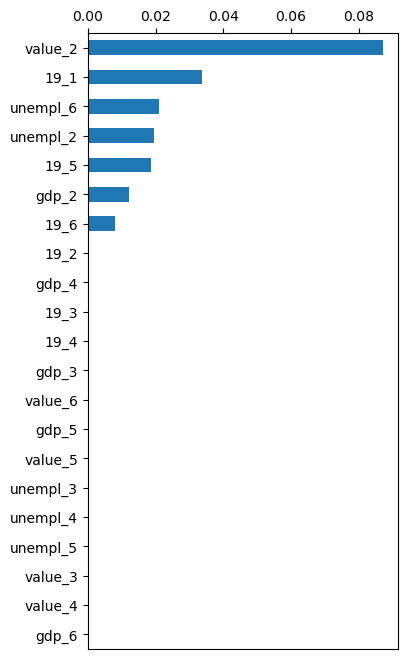

In [35]:
reg = tuners[-1].best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
plt.figure(figsize=(4,8))
pd.Series(reg.steps[-1][1].coef_, index=features_names_out).sort_values(
    ascending=True
).plot(kind="barh")
plt.gca().xaxis.tick_top()
plt.show()

#### Plot prediction (all features)

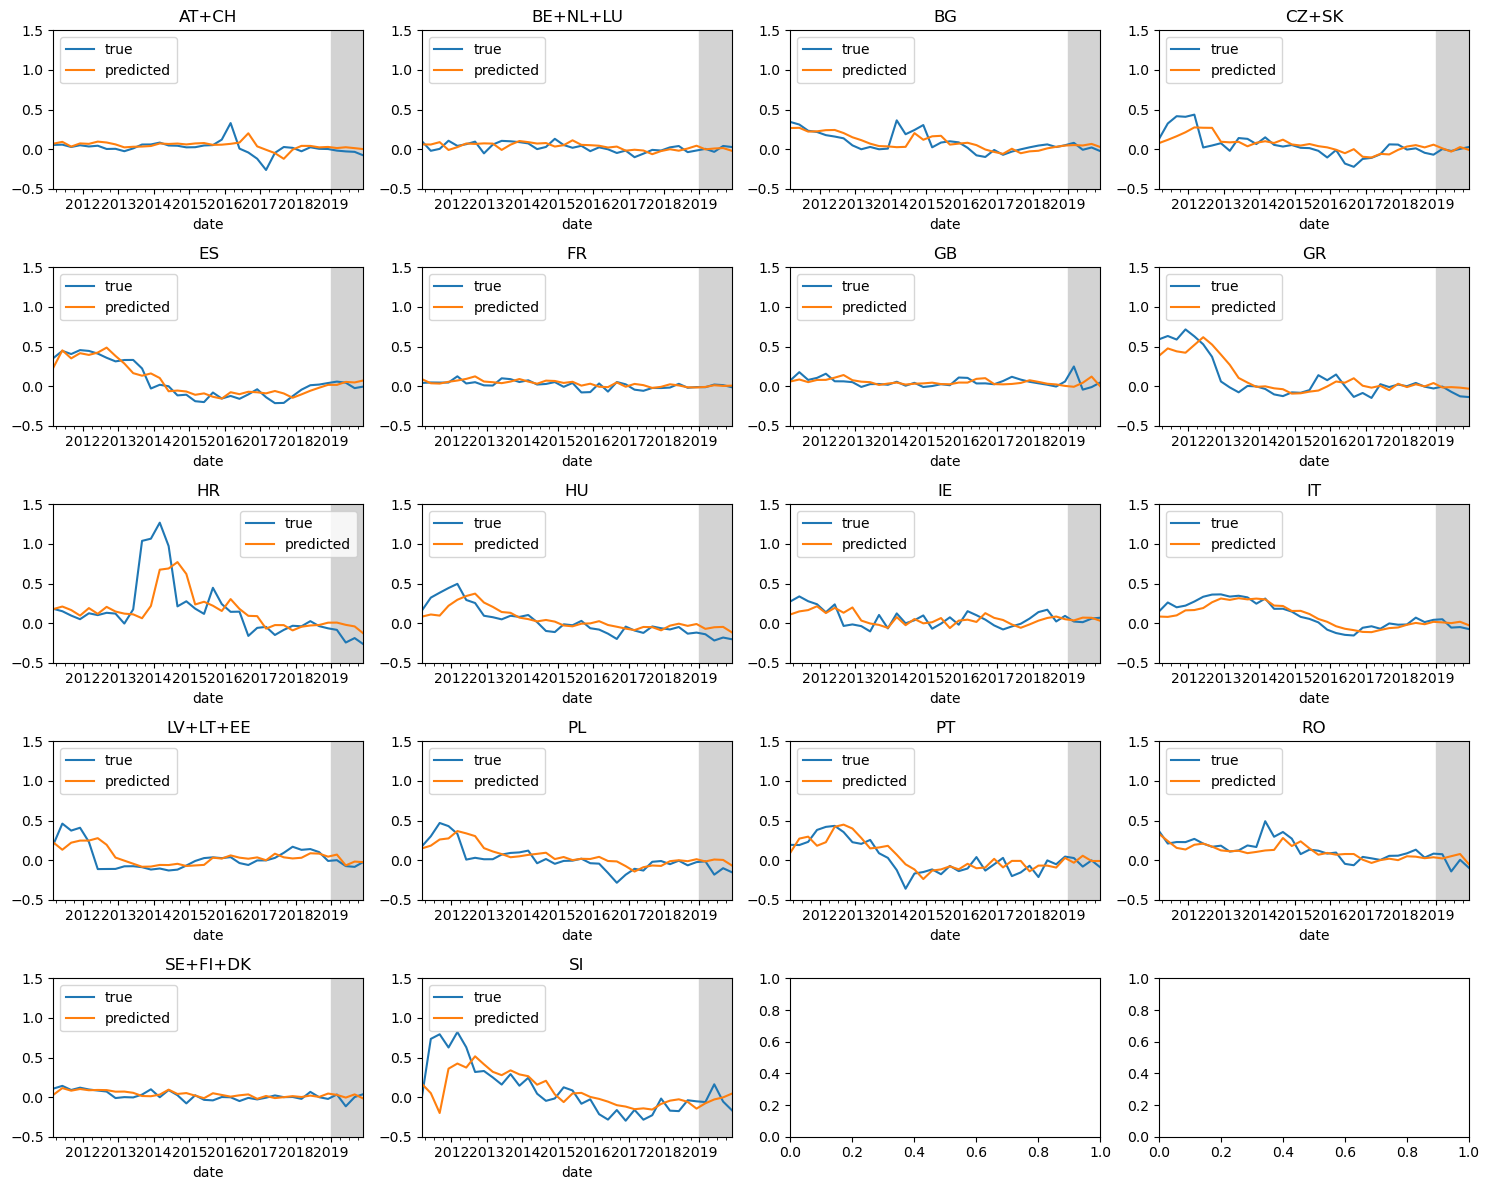

In [36]:
i = 6
reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2019", "2020"),
    t_max="2019",
)
plt.show()


#### Plot prediction (without own lags)

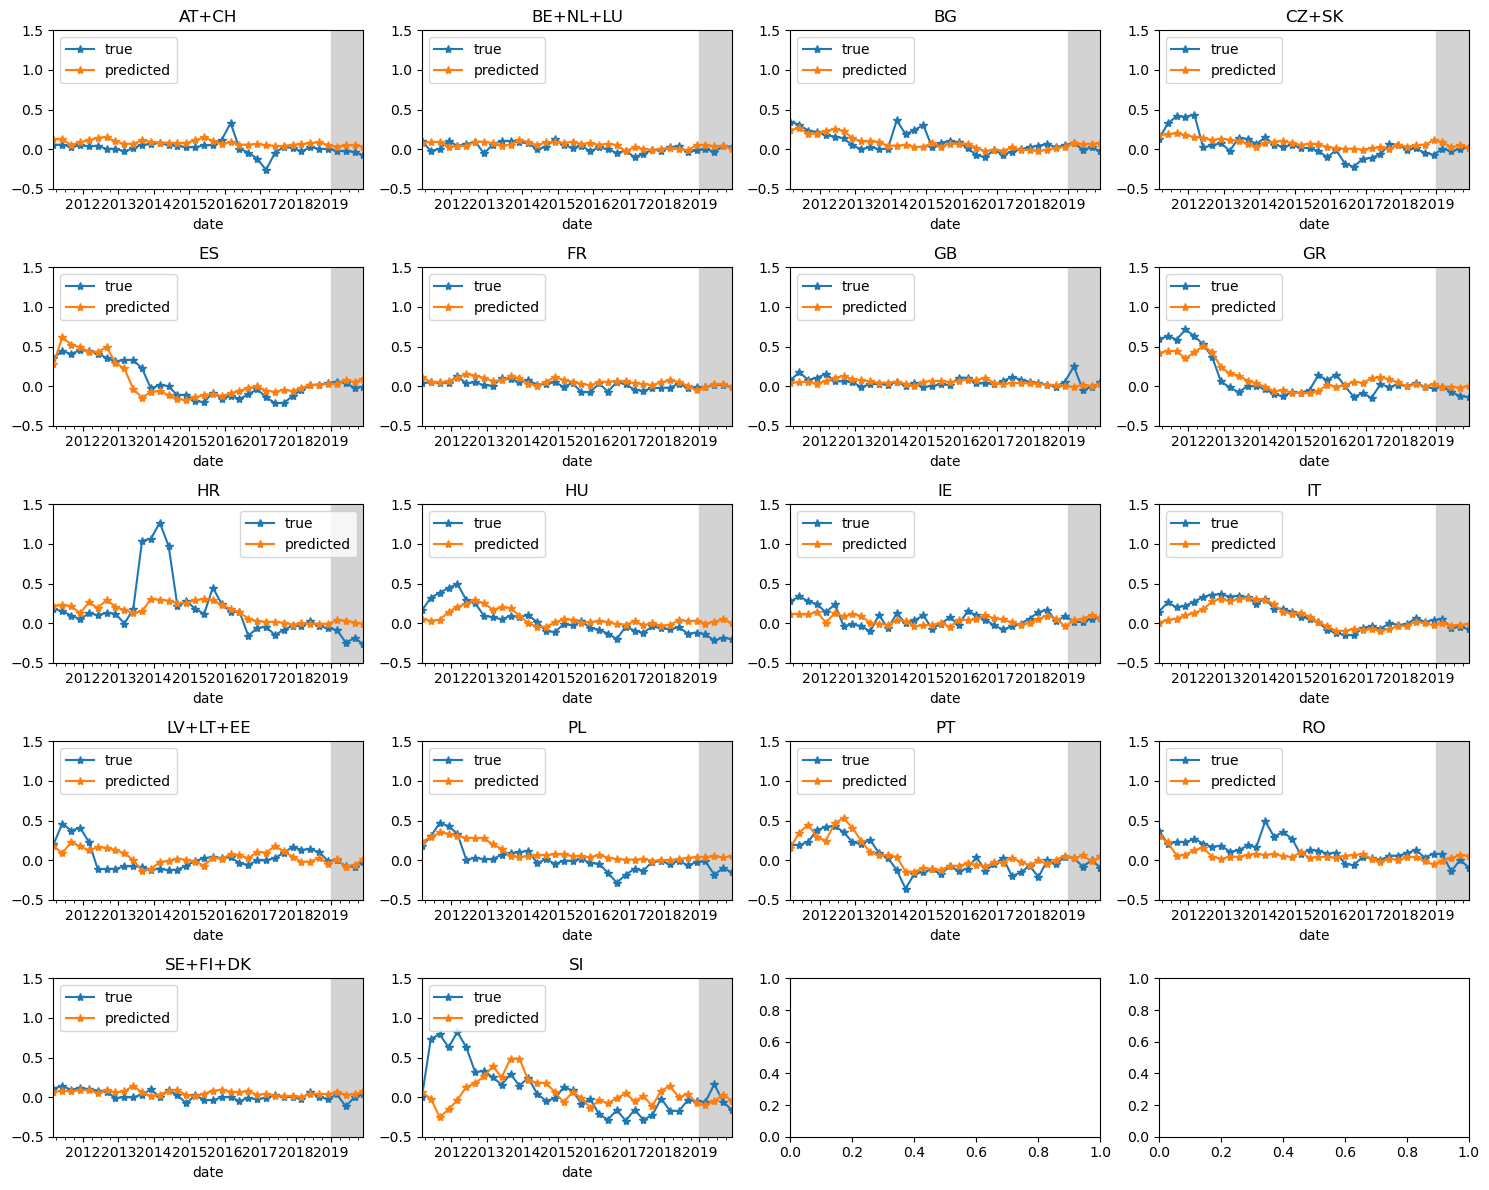

In [37]:
i = 2

reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="*",
    t_min="2011",
    vspan=("2019", "2020"),
    t_max="2019",
)
plt.show()

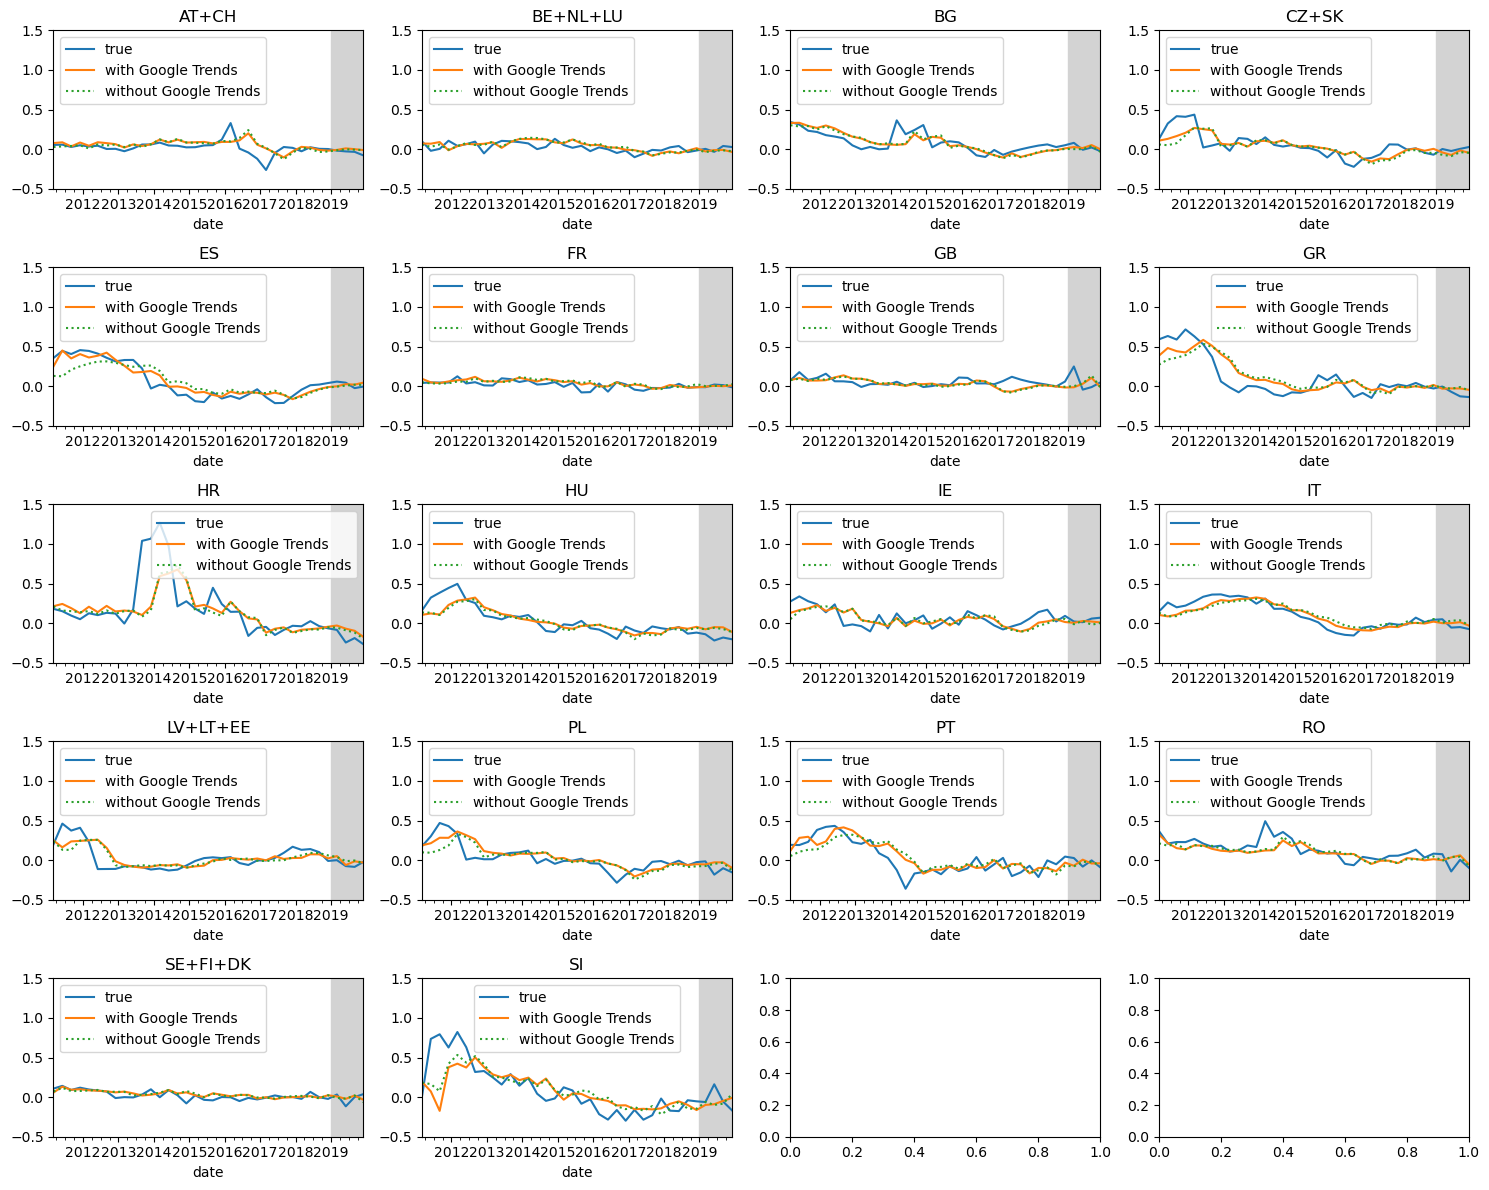

In [38]:
i1 = model_names.index("ar+19+gdp+unempl")
i2 = model_names.index("ar+gdp+unempl")

y_pred_i1 = eumf_eval.predict_all(tuners[i1].best_estimator_, train_stackeds[i1], test_stackeds[i1], cv_default)
y_pred_i2 = eumf_eval.predict_all(tuners[i2].best_estimator_, train_stackeds[i2], test_stackeds[i2], cv_default)

y_preds_all= {"with Google Trends": y_pred_i1, "without Google Trends": y_pred_i2}

fig, axs = eumf_eval.plot_predictions(
    y_preds_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2019", "2020"),
    t_max="2019",
    style={"without Google Trends": ":"}
)
plt.show()